<a href="https://colab.research.google.com/github/achmadbauravindah/Prediction-LSTM-GeneralElectricStock/blob/main/Prediction_LSTM_GeneralElectricStock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama: Achmad Bauravindah

Email: baurav99@gmail.com

Asal: Pasuruan, Jawa Timur

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM
from keras.callbacks import Callback, ModelCheckpoint, CSVLogger # Callback
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

### Download data

In [ ]:
# Download data from kaggle 
_ = ! git clone https://github.com/achmadbauravindah/ravin_kaggle_credential.git # get credential from kaggle
_ = ! pip install kaggle # install kaggle on drevice
_ = ! mkdir ~/.kaggle # make hidden folder .kaggle to configure credential
_ = ! cp ravin_kaggle_credential/kaggle.json ~/.kaggle/ # copy credential from github to .kaggle folder
_ = ! chmod 600 ~/.kaggle/kaggle.json # change access
_ = ! kaggle datasets download general-electric-company-dataset # which dataset to download
_ = ! unzip general-electric-company-dataset # unzip if data zipped

### Get Data from directory

In [ ]:
# Get data from direktori
data_path = 'General_Electric_Dataset.csv'
data = pd.read_csv(data_path)

### Show count data

In [ ]:
# Jumlah data
data.count()

Date         10737
Open         10737
High         10737
Low          10737
Close        10737
Adj Close    10737
Volume       10737
dtype: int64

## Plotting data

In [ ]:
# Set index dates to data
data["Date"] = pd.to_datetime(data.Date, dayfirst=True)
data.set_index("Date", inplace=True)

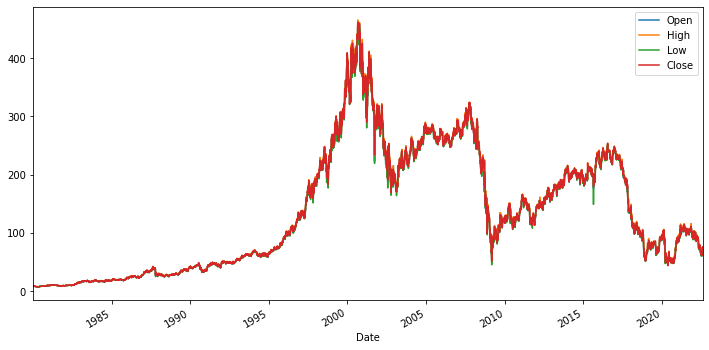

In [ ]:
# Plot All values per Year
data[['Open', 'High', 'Low','Close']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

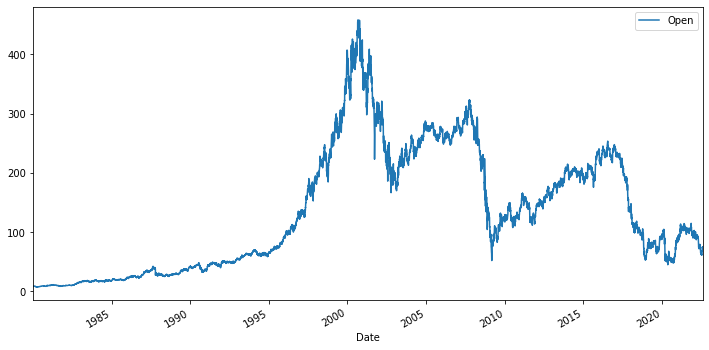

In [ ]:
# Plot Open values per Year
data[['Open']].plot(figsize=(12,6)).autoscale(axis='x', tight=True);

In [ ]:
# Reset indexing data
data_ge_open = data.reset_index()['Open'] # Column open to forecasting

### Skala data

In [ ]:
# Skala Data
skala_data = (data_ge_open.max()-data_ge_open.min())*0.1
print('Skala Data : ', skala_data)

Skala Data :  45.100159100000006


### Normalization

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
data_ge_open = np.array(data_ge_open)
data_ge_open = scaler.fit_transform(data_ge_open.reshape(-1,1))

### Split data (train: 80%, val: 20%)

In [ ]:
train_size = int(len(data_ge_open) * 0.80)
val_size = len(data_ge_open) - train_size

In [ ]:
train_size, val_size

(8589, 2148)

In [ ]:
train_data = data_ge_open[0:train_size,:] 
val_data  = data_ge_open[train_size:len(data_ge_open),:1]

### Create label from window/timestep (100 timestep)

In [ ]:
def createWindowDataset(dataset, time_step = 1):
  X = []
  y = []
  for i in range(len(dataset) - time_step - 1):
    fitur = dataset[i:(i+time_step), 0] # sederet fitur sebelum output timeseries
    X.append(fitur)
    y.append(dataset[i + time_step, 0]) # output data time series
  return np.array(X), np.array(y)

In [ ]:
X_train, y_train = createWindowDataset(train_data, 100)
X_val, y_val = createWindowDataset(val_data, 100)

In [ ]:
# Check Shape of X_train
X_train.shape

(8488, 100)

### Reshape data for Training Model LSTM 

In [ ]:
 #reshape input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

In [ ]:
# Check Shape of X_train after reshape
X_train.shape

(8488, 100, 1)

### Model Building

In [ ]:
model = tf.keras.models.Sequential([
            LSTM(60, return_sequences=True),
            LSTM(60),
            Dense(30, activation="relu"),
            Dense(10, activation="relu"),
            Dense(1),
])

model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

### Callback Setting

In [ ]:
# Create Callback

# 1 Callback untuk mendapatkan checkpoint setiap akurasi yang membaik dari tiap epoch
checkpoint_filepath = '/content/weights-improvement-{epoch:02d}-{val_mae:.2f}.hdf5'
checkpointCallback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_mae',
                                            mode='min',
                                            save_best_only=True)

# 2 Callback untuk menghentikan proses training pada rentang akurasi tertentu (di-set 100%)
class stopTrainingCallback(Callback):
  def on_epoch_end(self, epoch,logs={}):
    # Tidak memakai skala data (sebesar 45) karena nanti epoch yang di training hanya sedikit
    if ((logs.get('mae') <= 0.002) and (logs.get('val_mae') <= 0.002)) :
      print('\n Yeyy mae mencapai nilai kurang dari 0.002 🤩')
      self.model.stop_training = True

# 3 Callback mendapatkan accuracy, loss, val_loss, val_accuracy dan disimpan pada csv
log_csv = CSVLogger('prediction_generalelectric_result.csv', separator=';', append=False)

In [ ]:
callback_list = [checkpointCallback, stopTrainingCallback(), log_csv]

### Model Training

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=100, batch_size=256, callbacks=callback_list)

Epoch 1/100
34/34 [==============================] - 41s 1s/step - loss: 0.0084 - mae: 0.0782 - val_loss: 2.0705e-04 - val_mae: 0.0166
Epoch 2/100
34/34 [==============================] - 17s 497ms/step - loss: 2.0231e-04 - mae: 0.0137 - val_loss: 9.4008e-05 - val_mae: 0.0103
Epoch 3/100
34/34 [==============================] - 17s 501ms/step - loss: 1.3511e-04 - mae: 0.0103 - val_loss: 8.6927e-05 - val_mae: 0.0098
Epoch 4/100
34/34 [==============================] - 17s 498ms/step - loss: 1.2807e-04 - mae: 0.0098 - val_loss: 8.9033e-05 - val_mae: 0.0100
Epoch 5/100
34/34 [==============================] - 19s 566ms/step - loss: 1.2541e-04 - mae: 0.0095 - val_loss: 8.4289e-05 - val_mae: 0.0097
Epoch 6/100
34/34 [==============================] - 17s 502ms/step - loss: 1.2201e-04 - mae: 0.0092 - val_loss: 8.1700e-05 - val_mae: 0.0095
Epoch 7/100
34/34 [==============================] - 19s 556ms/step - loss: 1.1941e-04 - mae: 0.0091 - val_loss: 8.1943e-05 - val_mae: 0.0096
Epoch 8/100
3

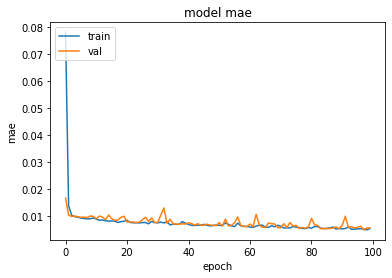

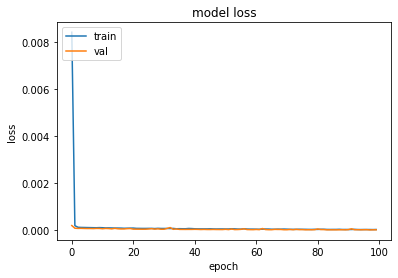

In [ ]:
# Show history of mae training model
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# Show history of loss training model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()